In [1]:
import numpy as np
import time
from ols import ols
from scipy import signal

def overlap_add_convolution1(x, h, B, K=None):
    """Overlap-Add convolution of x and h with block length B"""

    M = len(x)
    N = len(h)

    # Calculate the number of input blocks
    num_input_blocks = np.ceil(M / B).astype(int)

    # Pad x to an integer multiple of B
    xp = np.pad(x, (0, num_input_blocks*B), 'constant')

    # Your turn ...
    output_size = num_input_blocks * B + N - 1
    # waste of memory
    # what those indices
    # np.empty
    y = np.zeros((output_size,))
    
    # Convolve all blocks
    for n in range(num_input_blocks):
        # Extract the n-th input block
        xb = xp[n*B:(n+1)*B]

        # Fast convolution
        u = np.convolve(xb, h)
        #print("Direct add 1", u, n*B, n*B+len(u))

        # Overlap-Add the partial convolution result
        # two step process using np.empty
        # when do we assign
        # when do we add - find these indices 
        # try to avoid conditionals
        y[n*B:n*B+len(u)] += u

    return y[:M+N-1]


def overlap_add_convolution(x, h, B, K=None):
    """Overlap-Add convolution of x and h with block length B"""

    M = len(x)
    N = len(h)

    # Calculate the number of input blocks
    num_input_blocks = np.ceil(M / B).astype(int)
    
    # Pad x to an integer multiple of B
    # try to do this without padding
    xp = np.pad(x, (0, num_input_blocks*B), 'constant')

    # Initialize output array
    output_size = num_input_blocks * B + N - 1
    y = np.empty(output_size)
    #u = np.convolve(xp[:B], h) # h + B - 1
    y[:B + N - 1] = np.convolve(xp[:B], h) #u # 5
    #print("Initial ", y)
    
    # Convolve all blocks
    for n in range(1, num_input_blocks):
        # Extract the n-th input block
        xb = xp[n*B:(n+1)*B]

        # Fast convolution
        u = np.convolve(xb, h)
        #print("Direct add", u, n*B, n*B+len(u))
        
        # Overlap-Add the partial convolution result
        # Find indices for overlap
        start_idx = n*B # 2, 4, 6, 8
        #intermeidate_idx = start_idx + B # 4, 6, 8, 10
        end_idx = start_idx + len(u) # 7, 9, 11, 13
        values_added = len(u) - B
        value_at = start_idx + values_added #+ 1# 5, 7, 9, 11
        
        # add values
        #print(u, values_added, start_idx, value_at, end_idx)
        y[start_idx:value_at] += u[:values_added]
        y[value_at:end_idx] = u[values_added:]
        #print("Y originally", y)
        #print(start_idx, end_idx, end_idx-n*B, end_idx - (n+1)*B)
        #print("Corresponding y", y)

    return y[:M+N-1]


def overlap_add(x, h):
    # wikipedia
    M = len(h)
    Nx = len(x)
    N = 8 * (M - 1)
    step_size = N - (M-1)
    H = np.fft.fft(h, N)
    position = 0
    y = np.zeros(Nx + M - 1)
    print(step_size, position, Nx)
    while position + step_size <= Nx:
        y[position:(position+N)] += np.fft.ifft(np.fft.fft(x[position:(position+step_size)], N) * H).real
        position += step_size
    
    return y[:Nx+M-1]

def overlap_save(x, h):
    M = len(h)
    overlap = M - 1
    N = 8 * overlap
    step_size = N - overlap
    H = np.fft.fft(h, N)
    position = 0
    y = np.zeros(len(x) + M - 1)

    while position + N <= len(x):
        xt = x[position:(position+N)]
        yt = np.fft.ifft(np.fft.fft(xt, N) * H)
        y[position+overlap:(position+step_size)] = yt[M:]
        position += step_size
    
    return y[M-1:]

# Generate random input signal and filter
x = np.random.rand(3)
h = np.random.rand(2)

# Block lengths to test
L_values = [1, 2] #[2**i for i in range(1, 2)]

# Benchmark overlap-add method
print("Benchmarking overlap-add method...")
add_times = []
x_values = [100, 120, 256, 512, 1024, 1025]
h_values = [2, 3, 5, 7, 11, 13, 18, 32]
for i in x_values:
    for k in h_values:
        x = np.random.rand(i)
        h = np.random.rand(k)
        L = [np.random.randint(1, k) for l in range(5)]
        for L in L_values:
            start_time = time.time()
            y_add = overlap_add_convolution(x, h, L)
            #print("Correct version", y_add1)
            #y_add = overlap_add_convolution(x, h, L)
            #print("Overlap add", y_add)
            end_time = time.time()
            add_times.append(end_time - start_time)
            # Check if the output is correct
            y_add_direct = np.convolve(x, h, mode='full')
            #print("Direct", y_add_direct)
            if np.allclose(y_add_direct, y_add) == False:
                print("Error overlapp add")
        #print("Overlap-add times:", add_times)
        # Benchmark overlap-save method
        #print("Benchmarking overlap-save method...")
        save_times = []
        for L in L_values:
            start_time = time.time()
            y_add = overlap_add_convolution1(x, h, L) #ols(x, h, [L])
            end_time = time.time()
            save_times.append(end_time - start_time)
            # Check if the output is correct
            y_add_direct = np.convolve(x, h, mode='full')
            #print(y_add_direct, y_add)
            if np.allclose(y_add_direct, y_add) == False:
                print("Error overlap save")
        
#print("Overlap-save times:", save_times)


Benchmarking overlap-add method...


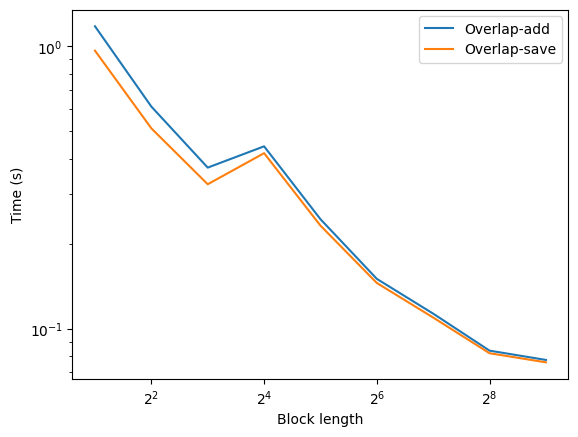

In [7]:
import matplotlib.pyplot as plt
# 0.01990977
# 0.46470858
# 0.90963377
m, n = 0, len(L_values)
# Plot the results
plt.plot(L_values[m:n], add_times[m:n], label="Overlap-add")
plt.plot(L_values[m:n], save_times[m:n], label="Overlap-save")
plt.legend()
plt.xlabel("Block length")
plt.ylabel("Time (s)")
plt.xscale("log", base=2)
plt.yscale("log")
plt.show()


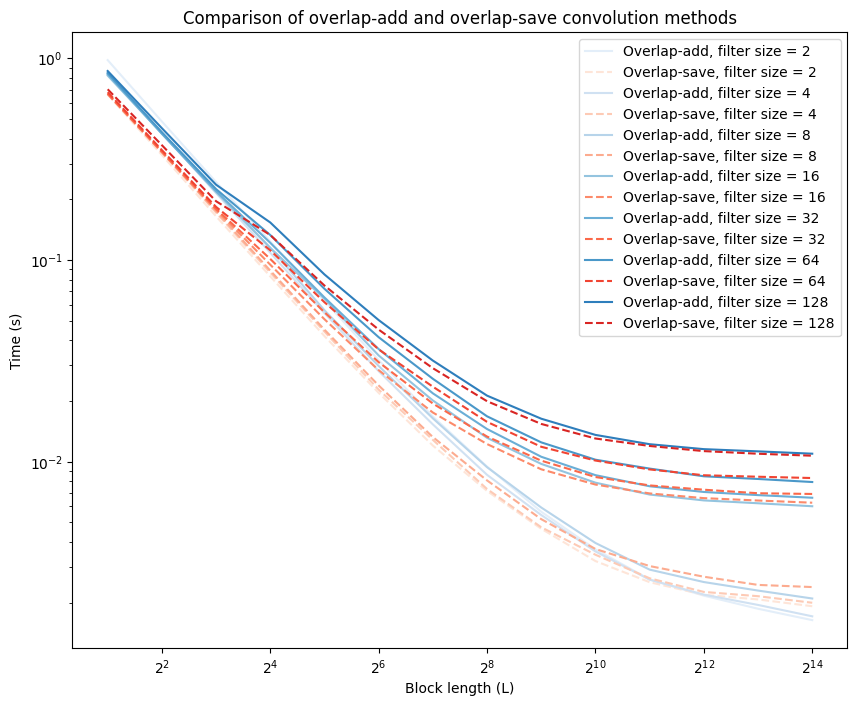

In [6]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Function to generate random input signal and filter
def generate_input(x_size, h_size):
    x = np.random.rand(x_size)
    h = np.random.rand(h_size)
    return x, h

# Function to benchmark overlap-add method
def benchmark_overlap_add(x, h, L_values):
    add_times = []
    for L in L_values:
        start_time = time.time()
        y_add = overlap_add_convolution(x, h, L)
        end_time = time.time()
        add_times.append(end_time - start_time)
        # Check if the output is correct
        y_add_direct = np.convolve(x, h, mode='full')
        if np.allclose(y_add_direct, y_add) == False:
            print("Error overlapp add")
    return add_times

# Function to benchmark overlap-save method
def benchmark_overlap_save(x, h, L_values):
    save_times = []
    for L in L_values:
        start_time = time.time()
        y_save = overlap_add_convolution1(x, h, L) #ols(x, h, [L])
        end_time = time.time()
        save_times.append(end_time - start_time)
        # Check if the output is correct
        y_save_direct = np.convolve(x, h, mode='full')
        if np.allclose(y_save_direct, y_save) == False:
            print("Error overlap save")
    return save_times

# Block lengths to test
L_values = [2**i for i in range(1, 15)]

# Filter sizes to test
filter_sizes = [2**i for i in range(1, 8)]

# Create a plot to showcase the comparison between overlap-add and overlap-save methods
plt.figure(figsize=(10, 8))

def benchmark_filters(filter_sizes, L_values):
    cmap = plt.get_cmap('Blues')
    cmap2 = plt.get_cmap('Reds')
    for i, filter_size in enumerate(filter_sizes):
        x_size = 2**20
        x, h = generate_input(x_size, filter_size)
        add_times = benchmark_overlap_add(x, h, L_values)
        save_times = benchmark_overlap_save(x, h, L_values)
        # Generate lighter shades for smaller filter sizes
        color = cmap((i + 1) / len(filter_sizes) * 0.7)
        color2 = cmap2((i + 1) / len(filter_sizes) * 0.7)
        label_add = f"Overlap-add, filter size = {filter_size}"
        label_save = f"Overlap-save, filter size = {filter_size}"
        plt.plot(L_values, add_times, color=color, label=label_add)
        plt.plot(L_values, save_times, color=color2, linestyle="--", label=label_save)
    plt.legend()
    plt.xlabel("Block length (L)")
    plt.ylabel("Time (s)")
    plt.xscale("log", base=2)
    plt.yscale("log")
    plt.title("Comparison of overlap-add and overlap-save convolution methods")
    plt.show()

benchmark_filters(filter_sizes, L_values)